## Imports

In [318]:
import pandas as pd
import os
from Bio import Affy
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

## Data Combining & Exporting

In [96]:
file_1 = 'C:/Research_Summer/ColorectalCancerData.csv' #Change for different files
file_2 = 'C:/Research_Summer/ColorectalPhenoData.csv'  #Change for different files

In [97]:
df1 = pd.read_csv(file_1, index_col=0)
df2 = pd.read_csv(file_2)

In [98]:
df2['geo_accession'] = df2['geo_accession'].astype(str)
sample_info = df2[['geo_accession', 'tissue:ch1']].set_index('geo_accession') #Change for different files
metadata_columns = df1.iloc[:, :2] #Change for different files
sample_columns = df1.iloc[:,2:] #Change for different files

In [99]:
sample_columns_transposed = sample_columns.T
merged_df = sample_columns_transposed.merge(sample_info, left_index=True, right_index=True)
merged_df_transposed = merged_df.T

In [100]:
case_control_row = merged_df_transposed.loc['tissue:ch1'] #Change for different files
merged_df_transposed = merged_df_transposed.drop('tissue:ch1') #Change for different files

In [101]:
df = pd.concat([metadata_columns, merged_df_transposed], axis=1)

In [102]:
df.loc['Case/Control'] = case_control_row

In [103]:
output_file_path = 'C:/Research_Summer/CompleteColorectalCancerData.csv' #Change for different files
df.to_csv(output_file_path, index=True)

In [104]:
df

,Chr,Position,GSM853240,GSM853241,GSM853242,GSM853243,GSM853244,GSM853245,GSM853246,GSM853247,...,GSM853354,GSM853355,GSM853356,GSM853357,GSM853358,GSM853359,GSM853360,GSM853361,GSM853362,GSM853363
rs1000002,3,185118462.0,AB,BB,AB,AB,AB,AA,AB,BB,...,AB,BB,NC,AB,AB,BB,AB,AB,BB,BB
rs1000003,3,99825597.0,AA,AB,AA,AA,AA,AA,AB,AB,...,AB,AA,AA,AB,AB,AA,AA,AA,AB,AB
rs10000030,4,103593179.0,BB,BB,BB,BB,BB,BB,AB,BB,...,BB,BB,BB,BB,BB,BB,BB,BB,BB,BB
rs10000037,4,38600725.0,BB,BB,BB,BB,BB,AB,BB,BB,...,BB,BB,AB,BB,BB,BB,BB,BB,BB,BB
rs10000041,4,165841405.0,AA,AB,AA,AA,AA,AB,AA,AA,...,AA,AA,AA,AA,AB,AB,AA,AA,AA,AB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rs9999908,4,53318206.0,BB,BB,BB,BB,BB,BB,AB,BB,...,BB,BB,BB,BB,BB,BB,BB,BB,BB,BB
rs9999944,4,148596445.0,BB,AB,BB,BB,BB,BB,AB,BB,...,BB,AB,BB,AA,BB,BB,BB,AB,NC,BB
rs9999954,4,1863426.0,BB,BB,BB,BB,BB,BB,BB,BB,...,BB,BB,BB,BB,BB,BB,BB,BB,BB,BB
rs9999963,4,84291761.0,AA,AA,AA,AA,AA,AA,AA,AA,...,AA,AA,AA,AA,AA,AA,NC,AA,AA,AA


In [105]:
case_control_counts = df.loc['Case/Control'].value_counts()
print("\nCase/Control counts:")
print(case_control_counts)


Case/Control counts:
Case/Control
colon tumor            62
normal colon mucosa    62
Name: count, dtype: int64


## Cleaning Data

In [170]:
input_file_path = 'C:/Research_Summer/CompleteBreastCancerData.csv' #Change for different files
output_file_path = 'C:/Research_Summer/ProcessedBreastCancerData.csv' #Change for different files
df = pd.read_csv(input_file_path, index_col=0)

In [171]:
case_control_counts = df.loc['Case/Control']
df = df.drop('Case/Control')
metadata_columns = df.iloc[:, :4] #Change for different files
sample_columns = df.iloc[:, 4:] #Change for different files

In [172]:
def filter_snps(row):
    unique_values = row.dropna().unique()
    if len(unique_values) == 1:
        return False
    no_call_count = row.isin(['No Call', 'NC']).sum()
    if no_call_count / len(row) > 0.10:
        return False
    return True

In [173]:
filtered_snps = sample_columns.apply(filter_snps, axis=1)
filtered_sample_columns = sample_columns[filtered_snps]

In [174]:
filtered_metadata_columns = metadata_columns.loc[filtered_sample_columns.index]

In [175]:
filtered_df = pd.concat([filtered_metadata_columns, filtered_sample_columns], axis=1)

In [176]:
filtered_df.loc['Case/Control'] = case_control_counts

In [177]:
filtered_df

,Chromosome,Physical Position,Allele A,Allele B,GSM417171,GSM417172,GSM417173,GSM417174,GSM417175,GSM417176,...,GSM417377,GSM417378,GSM417379,GSM417380,GSM417381,GSM417382,GSM417383,GSM417384,GSM417385,GSM417386
AFFX-SNP_10000979,17,64455333,A,G,AA,AA,BB,BB,AA,AB,...,BB,AA,BB,AA,BB,BB,AB,NC,NC,AB
AFFX-SNP_10026879,16,80881222,C,T,BB,BB,BB,AA,AB,AB,...,AB,AA,BB,BB,BB,AB,BB,BB,BB,AB
AFFX-SNP_10034687,18,63151294,A,C,AB,AA,AB,AA,AB,AB,...,BB,BB,AB,BB,BB,AB,AB,AB,BB,AB
AFFX-SNP_10036267,11,58318994,A,G,BB,AB,BB,BB,BB,AB,...,AB,AB,BB,BB,BB,AB,BB,AB,AB,BB
AFFX-SNP_10037362,20,2576109,C,T,AB,BB,AB,BB,BB,BB,...,BB,BB,BB,AB,BB,BB,BB,AB,AB,AB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-4304897,10,77131018,A,G,AA,AA,AA,AA,AA,AA,...,AA,AA,AA,AA,AA,AA,AA,AA,AB,AB
SNP_A-4304898,2,62051382,A,G,BB,BB,BB,BB,BB,BB,...,BB,BB,BB,BB,AB,BB,AB,BB,BB,BB
SNP_A-4304899,NaN,NaN,NaN,NaN,BB,BB,AB,BB,BB,NC,...,BB,AB,AB,BB,NC,BB,BB,BB,AB,AA
SNP_A-4304901,7,96761229,A,G,AA,AB,BB,BB,BB,BB,...,NC,BB,BB,BB,BB,BB,BB,BB,BB,BB


In [178]:
case_control_counts = filtered_df.loc['Case/Control'].value_counts()
print("\nCase/Control counts:")
print(case_control_counts)


Case/Control counts:
Case/Control
3.0    66
2.0    38
1.0     9
Name: count, dtype: int64


In [179]:
filtered_df.to_csv(output_file_path, index=True)

## Removing NC/ No Call in SNPs

In [228]:
input_file_path = 'C:/Research_Summer/ProcessedThyroidData.csv' #Change for different files
output_file_path = 'C:/Research_Summer/CompleteThyroidData.csv' #Change for different files

In [229]:
df = pd.read_csv(input_file_path, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_14892\4047810756.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, index_col=0)


In [230]:
case_control_counts = df.loc['Case/Control']
df = df.drop('Case/Control')
metadata_columns = df.iloc[:, :4] #Change for different files
sample_columns = df.iloc[:, 4:] #Change for different files

In [231]:
def replace_nc_with_mode(row):
    mode_value = row[row != 'No Call'].mode().iloc[0] if not row[row != 'No Call'].mode().empty else 'No Call'
    return row.replace('No Call', mode_value).replace('NC', mode_value)

In [232]:
sample_columns = sample_columns.apply(replace_nc_with_mode, axis=1)

In [233]:
def filter_snps(row):
    unique_values = row.dropna().unique()
    if len(unique_values) == 1:
        return False
    no_call_count = row.isin(['No Call', 'NC']).sum()
    if no_call_count / len(row) > 0.10:
        return False
    return True

In [234]:
filtered_snps = sample_columns.apply(filter_snps, axis=1)
filtered_sample_columns = sample_columns[filtered_snps]

In [235]:
filtered_metadata_columns = metadata_columns.loc[filtered_sample_columns.index]

In [236]:
filtered_df = pd.concat([filtered_metadata_columns, filtered_sample_columns], axis=1)

In [240]:
filtered_df.loc['Case/Control'] = case_control_counts

In [241]:
filtered_df

,Chromosome,Physical Position,Allele A,Allele B,GSM1636598,GSM1636599,GSM1636600,GSM1636601,GSM1636602,GSM1636603,...,GSM1637460,GSM1637461,GSM1637462,GSM1637463,GSM1637464,GSM1637465,GSM1637466,GSM1637468,GSM1637469,GSM1637470
AFFX-SNP_10000979,17,66943738,A,G,AA,AB,AB,BB,AA,AA,...,AB,BB,BB,AB,AB,AB,BB,BB,BB,AA
AFFX-SNP_10009702,17,14326088,C,T,AB,AB,AA,AB,AB,AB,...,AA,BB,AB,BB,AA,AB,AA,BB,AB,AB
AFFX-SNP_10015773,1,31709555,A,G,AA,AB,AB,BB,AB,AB,...,BB,BB,AB,AB,AB,BB,AB,BB,AB,AB
AFFX-SNP_10021569,2,106584554,A,C,AA,AB,AB,AA,AB,AB,...,AB,AA,AA,AA,AB,AA,AA,AA,AA,AA
AFFX-SNP_10026879,16,82323721,C,T,AB,AB,AB,BB,BB,AB,...,BB,AB,AA,BB,AB,AB,AB,BB,BB,AB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-8717612,20,9596287.0,G,T,AA,AA,AA,AB,AA,AA,...,AB,AA,AA,AA,AA,AA,AA,AA,AA,AA
SNP_A-8717613,8,26098539.0,C,T,BB,AB,BB,AA,AB,AA,...,AB,BB,AA,AB,AB,AB,AA,AB,BB,AB
SNP_A-8717614,X,43715184.0,A,G,BB,BB,BB,BB,BB,BB,...,BB,BB,BB,BB,BB,BB,BB,BB,BB,BB
SNP_A-8717615,5,135537777.0,A,G,BB,BB,BB,AB,BB,AB,...,AB,AB,AB,AB,AB,BB,AB,AB,AB,AB


In [238]:
filtered_df.to_csv(output_file_path, index=True)

## Encoding of Data

In [118]:
input_file_path = 'C:/Research_Summer/CompleteBreastCancerData.csv' #Change for different files
output_file_path = 'C:/Research_Summer/EncodedBreastCancerData.csv' #Change for different files

In [119]:
df = pd.read_csv(input_file_path, header=0, index_col=0)

In [120]:
case_control_info = df.iloc[-1, 4:]  # Change for different files
case_control_label = df.index[-1]

In [121]:
case_control_info

GSM417171    2
GSM417172    2
GSM417173    3
GSM417174    3
GSM417175    3
            ..
GSM417382    1
GSM417383    2
GSM417384    3
GSM417385    2
GSM417386    2
Name: Case/Control, Length: 119, dtype: object

In [122]:
value_counts = case_control_info.value_counts(dropna=False)

# Print counts
print("Counts of each value in 'Case/Control':")
print(value_counts)

# Explicitly count the blanks (NaN values)
blank_count = case_control_info.isna().sum()
print(f"Count of blanks: {blank_count}")

Counts of each value in 'Case/Control':
Case/Control
3      66
2      38
1       9
NaN     6
Name: count, dtype: int64
Count of blanks: 6


In [123]:
filtered_case_control_info = case_control_info.dropna()

In [124]:
def map_case_control(value):
    if value == '1' or value == '2':
        return 'Control'
    elif value == '3':
        return 'Case'
    else:
        return value

filtered_case_control_info = filtered_case_control_info.apply(map_case_control)
case_control_numeric = filtered_case_control_info.map({'Control': 0, 'Case': 1})

#case_control_info = case_control_info.map({'normal colon mucosa': 'Control', 'colon tumor': 'Case'}).fillna(case_control_info) #Change for different files
#case_control_numeric = case_control_info.map({'Control': 0, 'Case': 1})

In [125]:
case_control_numeric

GSM417171    0
GSM417172    0
GSM417173    1
GSM417174    1
GSM417175    1
            ..
GSM417382    0
GSM417383    0
GSM417384    1
GSM417385    0
GSM417386    0
Name: Case/Control, Length: 113, dtype: int64

In [126]:
df = df.iloc[:-1, :]

In [136]:
metadata_cols = df.iloc[:, :4]  # Change for different files
sample_cols = df.iloc[:, 4:]  # Change for different files

In [141]:
filtered_sample_cols = sample_cols.loc[:, sample_cols.columns.isin(filtered_case_control_info.index)]

In [144]:
encoded_sample_cols = pd.DataFrame(index=filtered_sample_cols.index, columns=filtered_sample_cols.columns)

In [146]:
for idx, row in filtered_sample_cols.iterrows():
    snp_genotypes = row.values
    
    snp_data = pd.DataFrame({
        'Genotype': snp_genotypes,
        'Case/Control': case_control_numeric.values
    })
    mean_encodings = snp_data.groupby('Genotype')['Case/Control'].mean().to_dict()
    encoded_sample_cols.loc[idx] = row.map(mean_encodings)

In [147]:
final_df = pd.concat([metadata_cols, encoded_sample_cols], axis=1)

In [148]:
final_df

,Chromosome,Physical Position,Allele A,Allele B,GSM417171,GSM417172,GSM417173,GSM417174,GSM417175,GSM417176,...,GSM417377,GSM417378,GSM417379,GSM417380,GSM417381,GSM417382,GSM417383,GSM417384,GSM417385,GSM417386
AFFX-SNP_10000979,17,64455333,A,G,0.714286,0.714286,0.594595,0.594595,0.714286,0.5,...,0.594595,0.714286,0.594595,0.714286,0.594595,0.594595,0.5,0.5,0.5,0.5
AFFX-SNP_10026879,16,80881222,C,T,0.576923,0.576923,0.576923,0.652174,0.552632,0.552632,...,0.552632,0.652174,0.576923,0.576923,0.576923,0.552632,0.576923,0.576923,0.576923,0.552632
AFFX-SNP_10034687,18,63151294,A,C,0.536585,0.714286,0.536585,0.714286,0.536585,0.536585,...,0.6,0.6,0.536585,0.6,0.6,0.536585,0.536585,0.536585,0.6,0.536585
AFFX-SNP_10036267,11,58318994,A,G,0.623377,0.5,0.623377,0.623377,0.623377,0.5,...,0.5,0.5,0.623377,0.623377,0.623377,0.5,0.623377,0.5,0.5,0.623377
AFFX-SNP_10037362,20,2576109,C,T,0.592593,0.575,0.592593,0.575,0.575,0.575,...,0.575,0.575,0.575,0.592593,0.575,0.575,0.575,0.592593,0.592593,0.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-4304896,NaN,NaN,NaN,NaN,0.536842,0.536842,0.769231,1.0,0.769231,0.536842,...,0.536842,0.536842,0.536842,0.536842,0.536842,0.536842,0.536842,0.536842,0.536842,0.536842
SNP_A-4304897,10,77131018,A,G,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,...,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,0.526316,0.526316
SNP_A-4304898,2,62051382,A,G,0.58,0.58,0.58,0.58,0.58,0.58,...,0.58,0.58,0.58,0.58,0.583333,0.58,0.583333,0.58,0.58,0.58
SNP_A-4304899,NaN,NaN,NaN,NaN,0.544118,0.544118,0.641026,0.544118,0.544118,0.544118,...,0.544118,0.641026,0.641026,0.544118,0.544118,0.544118,0.544118,0.544118,0.641026,0.666667


In [150]:
case_control_row = [''] * 4 + filtered_case_control_info.tolist() #Change for different files
case_control_row_df = pd.DataFrame([case_control_row], columns=final_df.columns)
case_control_row_df.index = ['Case/Control']

In [151]:
case_control_row_df

,Chromosome,Physical Position,Allele A,Allele B,GSM417171,GSM417172,GSM417173,GSM417174,GSM417175,GSM417176,...,GSM417377,GSM417378,GSM417379,GSM417380,GSM417381,GSM417382,GSM417383,GSM417384,GSM417385,GSM417386
Case/Control,,,,,Control,Control,Case,Case,Case,Control,...,Control,Case,Case,Case,Case,Control,Control,Case,Control,Control


In [152]:
final_df = pd.concat([final_df, case_control_row_df])

In [67]:
print("Final DataFrame shape:", final_df.shape)
print("Final DataFrame head:")
print(final_df.head())

Final DataFrame shape: (794246, 229)
Final DataFrame head:
                  Chromosome Physical Position Allele A Allele B GSM1636598  \
AFFX-SNP_10000979         17          66943738        A        G    0.52381   
AFFX-SNP_10009702         17          14326088        C        T    0.44898   
AFFX-SNP_10015773          1          31709555        A        G   0.444444   
AFFX-SNP_10021569          2         106584554        A        C   0.419118   
AFFX-SNP_10026879         16          82323721        C        T   0.395604   

                  GSM1636599 GSM1636600 GSM1636601 GSM1636602 GSM1636603  ...  \
AFFX-SNP_10000979   0.394495   0.394495   0.418919    0.52381    0.52381  ...   
AFFX-SNP_10009702    0.44898   0.444444    0.44898    0.44898    0.44898  ...   
AFFX-SNP_10015773   0.377049   0.377049   0.494118   0.377049   0.377049  ...   
AFFX-SNP_10021569   0.410959   0.410959   0.419118   0.410959   0.410959  ...   
AFFX-SNP_10026879   0.395604   0.395604   0.446281   0.446281

In [153]:
final_df

,Chromosome,Physical Position,Allele A,Allele B,GSM417171,GSM417172,GSM417173,GSM417174,GSM417175,GSM417176,...,GSM417377,GSM417378,GSM417379,GSM417380,GSM417381,GSM417382,GSM417383,GSM417384,GSM417385,GSM417386
AFFX-SNP_10000979,17,64455333,A,G,0.714286,0.714286,0.594595,0.594595,0.714286,0.5,...,0.594595,0.714286,0.594595,0.714286,0.594595,0.594595,0.5,0.5,0.5,0.5
AFFX-SNP_10026879,16,80881222,C,T,0.576923,0.576923,0.576923,0.652174,0.552632,0.552632,...,0.552632,0.652174,0.576923,0.576923,0.576923,0.552632,0.576923,0.576923,0.576923,0.552632
AFFX-SNP_10034687,18,63151294,A,C,0.536585,0.714286,0.536585,0.714286,0.536585,0.536585,...,0.6,0.6,0.536585,0.6,0.6,0.536585,0.536585,0.536585,0.6,0.536585
AFFX-SNP_10036267,11,58318994,A,G,0.623377,0.5,0.623377,0.623377,0.623377,0.5,...,0.5,0.5,0.623377,0.623377,0.623377,0.5,0.623377,0.5,0.5,0.623377
AFFX-SNP_10037362,20,2576109,C,T,0.592593,0.575,0.592593,0.575,0.575,0.575,...,0.575,0.575,0.575,0.592593,0.575,0.575,0.575,0.592593,0.592593,0.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-4304897,10,77131018,A,G,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,...,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,0.597826,0.526316,0.526316
SNP_A-4304898,2,62051382,A,G,0.58,0.58,0.58,0.58,0.58,0.58,...,0.58,0.58,0.58,0.58,0.583333,0.58,0.583333,0.58,0.58,0.58
SNP_A-4304899,NaN,NaN,NaN,NaN,0.544118,0.544118,0.641026,0.544118,0.544118,0.544118,...,0.544118,0.641026,0.641026,0.544118,0.544118,0.544118,0.544118,0.544118,0.641026,0.666667
SNP_A-4304901,7,96761229,A,G,0.5,0.875,0.563107,0.563107,0.563107,0.563107,...,0.563107,0.563107,0.563107,0.563107,0.563107,0.563107,0.563107,0.563107,0.563107,0.563107


In [154]:
final_df.to_csv(output_file_path, index=True)

In [155]:
df = pd.read_csv(output_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_24696\1030897790.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file_path, header=0, index_col=0)


## Removing Metadata Information

In [193]:
input_file_path = 'C:/Research_Summer/EncodedThyroidData.csv' #Change for different files
output_file_path = 'C:/Research_Summer/FinalizedThyroidData.csv' #Change for different files

In [194]:
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_24696\2354946703.py:1: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_pat

In [195]:
df

,Chromosome,Physical Position,Allele A,Allele B,GSM1636598,GSM1636599,GSM1636600,GSM1636601,GSM1636602,GSM1636603,...,GSM1637460,GSM1637461,GSM1637462,GSM1637463,GSM1637464,GSM1637465,GSM1637466,GSM1637468,GSM1637469,GSM1637470
AFFX-SNP_10000979,17,66943738,A,G,0.52381,0.394495,0.394495,0.418919,0.52381,0.52381,...,0.394495,0.418919,0.418919,0.394495,0.394495,0.394495,0.418919,0.418919,0.418919,0.52381
AFFX-SNP_10009702,17,14326088,C,T,0.44898,0.44898,0.444444,0.44898,0.44898,0.44898,...,0.444444,0.30303,0.44898,0.30303,0.444444,0.44898,0.444444,0.30303,0.44898,0.44898
AFFX-SNP_10015773,1,31709555,A,G,0.444444,0.377049,0.377049,0.494118,0.377049,0.377049,...,0.494118,0.494118,0.377049,0.377049,0.377049,0.494118,0.377049,0.494118,0.377049,0.377049
AFFX-SNP_10021569,2,106584554,A,C,0.419118,0.410959,0.410959,0.419118,0.410959,0.410959,...,0.410959,0.419118,0.419118,0.419118,0.410959,0.419118,0.419118,0.419118,0.419118,0.419118
AFFX-SNP_10026879,16,82323721,C,T,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604,...,0.446281,0.395604,0.461538,0.446281,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-8717612,20,9596287,G,T,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.5517241379310345,0.40932642487046633,0.40932642487046633,...,0.5517241379310345,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633
SNP_A-8717613,8,26098539,C,T,0.5,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.4406779661016949,...,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.38181818181818183,0.38181818181818183,0.4406779661016949,0.38181818181818183,0.5,0.38181818181818183
SNP_A-8717614,X,43715184,A,G,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,...,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794
SNP_A-8717615,5,135537777,A,G,0.5113636363636364,0.5113636363636364,0.5113636363636364,0.33884297520661155,0.5113636363636364,0.33884297520661155,...,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.5113636363636364,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155


In [196]:
df_metadata_cols = df.columns[:4]

In [197]:
df = df.drop(df_metadata_cols, axis=1)
df

,GSM1636598,GSM1636599,GSM1636600,GSM1636601,GSM1636602,GSM1636603,GSM1636604,GSM1636605,GSM1636606,GSM1636607,...,GSM1637460,GSM1637461,GSM1637462,GSM1637463,GSM1637464,GSM1637465,GSM1637466,GSM1637468,GSM1637469,GSM1637470
AFFX-SNP_10000979,0.52381,0.394495,0.394495,0.418919,0.52381,0.52381,0.394495,0.394495,0.418919,0.418919,...,0.394495,0.418919,0.418919,0.394495,0.394495,0.394495,0.418919,0.418919,0.418919,0.52381
AFFX-SNP_10009702,0.44898,0.44898,0.444444,0.44898,0.44898,0.44898,0.44898,0.44898,0.44898,0.44898,...,0.444444,0.30303,0.44898,0.30303,0.444444,0.44898,0.444444,0.30303,0.44898,0.44898
AFFX-SNP_10015773,0.444444,0.377049,0.377049,0.494118,0.377049,0.377049,0.444444,0.494118,0.377049,0.494118,...,0.494118,0.494118,0.377049,0.377049,0.377049,0.494118,0.377049,0.494118,0.377049,0.377049
AFFX-SNP_10021569,0.419118,0.410959,0.410959,0.419118,0.410959,0.410959,0.410959,0.410959,0.419118,0.419118,...,0.410959,0.419118,0.419118,0.419118,0.410959,0.419118,0.419118,0.419118,0.419118,0.419118
AFFX-SNP_10026879,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604,0.446281,0.395604,0.395604,0.446281,...,0.446281,0.395604,0.461538,0.446281,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-8717612,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.5517241379310345,0.40932642487046633,0.40932642487046633,0.5517241379310345,0.5517241379310345,0.40932642487046633,0.40932642487046633,...,0.5517241379310345,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633
SNP_A-8717613,0.5,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.4406779661016949,0.4406779661016949,0.4406779661016949,0.4406779661016949,0.5,...,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.38181818181818183,0.38181818181818183,0.4406779661016949,0.38181818181818183,0.5,0.38181818181818183
SNP_A-8717614,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,...,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794
SNP_A-8717615,0.5113636363636364,0.5113636363636364,0.5113636363636364,0.33884297520661155,0.5113636363636364,0.33884297520661155,0.5113636363636364,0.33884297520661155,0.33884297520661155,0.33884297520661155,...,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.5113636363636364,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155


In [198]:
df.to_csv(output_file_path, index=True)

In [199]:
df = pd.read_csv(output_file_path, header=0, index_col=0)
df

C:\Users\colte\AppData\Local\Temp\ipykernel_24696\828876201.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(output_file_path, header=

,GSM1636598,GSM1636599,GSM1636600,GSM1636601,GSM1636602,GSM1636603,GSM1636604,GSM1636605,GSM1636606,GSM1636607,...,GSM1637460,GSM1637461,GSM1637462,GSM1637463,GSM1637464,GSM1637465,GSM1637466,GSM1637468,GSM1637469,GSM1637470
AFFX-SNP_10000979,0.52381,0.394495,0.394495,0.418919,0.52381,0.52381,0.394495,0.394495,0.418919,0.418919,...,0.394495,0.418919,0.418919,0.394495,0.394495,0.394495,0.418919,0.418919,0.418919,0.52381
AFFX-SNP_10009702,0.44898,0.44898,0.444444,0.44898,0.44898,0.44898,0.44898,0.44898,0.44898,0.44898,...,0.444444,0.30303,0.44898,0.30303,0.444444,0.44898,0.444444,0.30303,0.44898,0.44898
AFFX-SNP_10015773,0.444444,0.377049,0.377049,0.494118,0.377049,0.377049,0.444444,0.494118,0.377049,0.494118,...,0.494118,0.494118,0.377049,0.377049,0.377049,0.494118,0.377049,0.494118,0.377049,0.377049
AFFX-SNP_10021569,0.419118,0.410959,0.410959,0.419118,0.410959,0.410959,0.410959,0.410959,0.419118,0.419118,...,0.410959,0.419118,0.419118,0.419118,0.410959,0.419118,0.419118,0.419118,0.419118,0.419118
AFFX-SNP_10026879,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604,0.446281,0.395604,0.395604,0.446281,...,0.446281,0.395604,0.461538,0.446281,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-8717612,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.5517241379310345,0.40932642487046633,0.40932642487046633,0.5517241379310345,0.5517241379310345,0.40932642487046633,0.40932642487046633,...,0.5517241379310345,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633
SNP_A-8717613,0.5,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.4406779661016949,0.4406779661016949,0.4406779661016949,0.4406779661016949,0.5,...,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.38181818181818183,0.38181818181818183,0.4406779661016949,0.38181818181818183,0.5,0.38181818181818183
SNP_A-8717614,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,...,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794
SNP_A-8717615,0.5113636363636364,0.5113636363636364,0.5113636363636364,0.33884297520661155,0.5113636363636364,0.33884297520661155,0.5113636363636364,0.33884297520661155,0.33884297520661155,0.33884297520661155,...,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.5113636363636364,0.33884297520661155,0.33884297520661155,0.33884297520661155,0.33884297520661155


## Feature Selection - AMGM Method

In [275]:
def calculate_amgm(X):
    """
    Calculate AMGM for each feature (row) in the dataset X.
    
    Parameters:
    X (numpy array): The input data array with shape (n_features, n_samples)
    
    Returns:
    amgm_values (numpy array): The AMGM values for each feature (row)
    """
    N = X.shape[1]
    
    exp_X = np.exp(X)
    amgm_values = (np.mean(exp_X, axis=1)) / (np.exp(np.mean(X, axis=1)))
    
    return amgm_values

In [276]:
input_file_path = 'C:/Research_Summer/FinalizedThyroidData.csv' #Change for different files

In [277]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_24696\562430524.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0

In [278]:
features_df

,GSM1636598,GSM1636599,GSM1636600,GSM1636601,GSM1636602,GSM1636603,GSM1636604,GSM1636605,GSM1636606,GSM1636607,...,GSM1637460,GSM1637461,GSM1637462,GSM1637463,GSM1637464,GSM1637465,GSM1637466,GSM1637468,GSM1637469,GSM1637470
AFFX-SNP_10000979,0.52381,0.394495,0.394495,0.418919,0.52381,0.52381,0.394495,0.394495,0.418919,0.418919,...,0.394495,0.418919,0.418919,0.394495,0.394495,0.394495,0.418919,0.418919,0.418919,0.52381
AFFX-SNP_10009702,0.44898,0.44898,0.444444,0.44898,0.44898,0.44898,0.44898,0.44898,0.44898,0.44898,...,0.444444,0.30303,0.44898,0.30303,0.444444,0.44898,0.444444,0.30303,0.44898,0.44898
AFFX-SNP_10015773,0.444444,0.377049,0.377049,0.494118,0.377049,0.377049,0.444444,0.494118,0.377049,0.494118,...,0.494118,0.494118,0.377049,0.377049,0.377049,0.494118,0.377049,0.494118,0.377049,0.377049
AFFX-SNP_10021569,0.419118,0.410959,0.410959,0.419118,0.410959,0.410959,0.410959,0.410959,0.419118,0.419118,...,0.410959,0.419118,0.419118,0.419118,0.410959,0.419118,0.419118,0.419118,0.419118,0.419118
AFFX-SNP_10026879,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604,0.446281,0.395604,0.395604,0.446281,...,0.446281,0.395604,0.461538,0.446281,0.395604,0.395604,0.395604,0.446281,0.446281,0.395604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SNP_A-8717610,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,...,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285,0.42410714285714285
SNP_A-8717612,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.5517241379310345,0.40932642487046633,0.40932642487046633,0.5517241379310345,0.5517241379310345,0.40932642487046633,0.40932642487046633,...,0.5517241379310345,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633,0.40932642487046633
SNP_A-8717613,0.5,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.4406779661016949,0.4406779661016949,0.4406779661016949,0.4406779661016949,0.5,...,0.38181818181818183,0.5,0.4406779661016949,0.38181818181818183,0.38181818181818183,0.38181818181818183,0.4406779661016949,0.38181818181818183,0.5,0.38181818181818183
SNP_A-8717614,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,...,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794,0.42792792792792794


In [283]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [284]:
amgm_values = calculate_amgm(X)

In [285]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [286]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [575822 114143  71716 499736 767356 750187 514835 412607 468562 385721]
Top AMGM values: [1.00529797 1.0052982  1.00529837 1.00529853 1.00529853 1.00529858
 1.00529869 1.00529874 1.00529877 1.00529877]


## Feature Selection - Cosine Method & Autoencoder - Thyroid

In [287]:
def filter_redundant_features(X, relevant_indices, threshold=0.9):
    relevant_features = X[relevant_indices, :]
    cos_sim_matrix = cosine_similarity(relevant_features)
    
    to_keep = []
    to_drop = set()
    for i in range(cos_sim_matrix.shape[0]):
        if i not in to_drop:
            to_keep.append(relevant_indices[i])
            for j in range(i + 1, cos_sim_matrix.shape[0]):
                if cos_sim_matrix[i, j] > threshold:
                    to_drop.add(relevant_indices[j])
    return to_keep

In [288]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [289]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr


In [290]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [322]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:200] 

In [323]:
X_selected = X[selected_indices, :].T 

In [324]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [325]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [326]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [327]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [328]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 100)               20100     
                                                                 
 dense_121 (Dense)           (None, 50)                5050      
                                                                 
 dense_122 (Dense)           (None, 100)               5100      
                                                                 
 dense_123 (Dense)           (None, 200)               20200     
                                                                 
 dense_124 (Dense)           (None, 1)                 201       
                                                                 
Total params: 50651 (197.86 KB)
Trainable params: 50651 (197.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [329]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
5/5 [==============================] - 2s 93ms/step - loss: 0.7004 - accuracy: 0.5350 - val_loss: 0.6589 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 0.6575 - accuracy: 0.5924 - val_loss: 0.6247 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 0.5770 - accuracy: 0.8535 - val_loss: 0.5157 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 0.4483 - accuracy: 0.9427 - val_loss: 0.3800 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 0.2991 - accuracy: 0.9682 - val_loss: 0.2435 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 0.1614 - accuracy: 0.9873 - val_loss: 0.1584 - val_accuracy: 0.9565 - lr: 0.0010
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0796 - accuracy

In [334]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

2/2 [==============================] - 0s 3ms/step
Accuracy: 0.9777777777777777
F1 Score: 0.9600000000000001


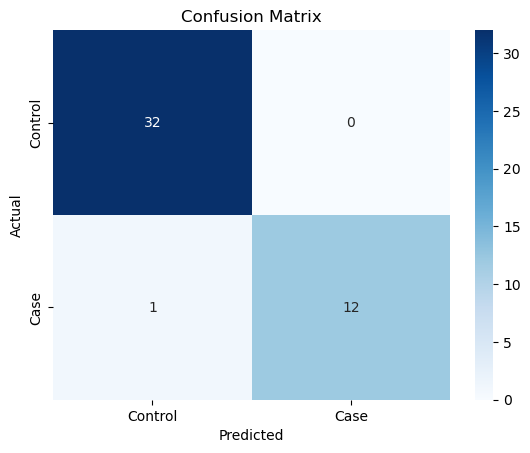

In [331]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [335]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 0.9777777777777777
F1 Score: 0.9600000000000001
Specificity: 1.0
Sensitivity: 0.9230769230769231


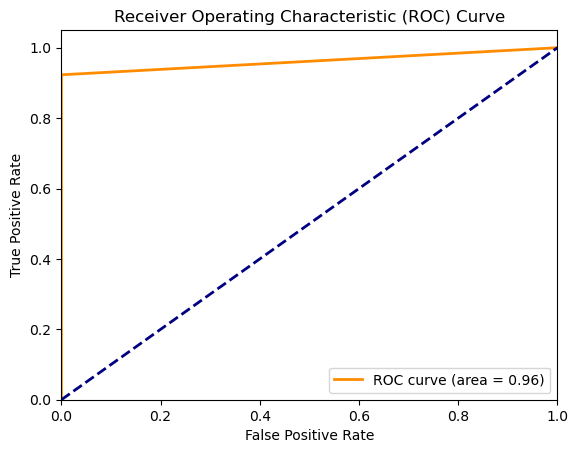

In [332]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

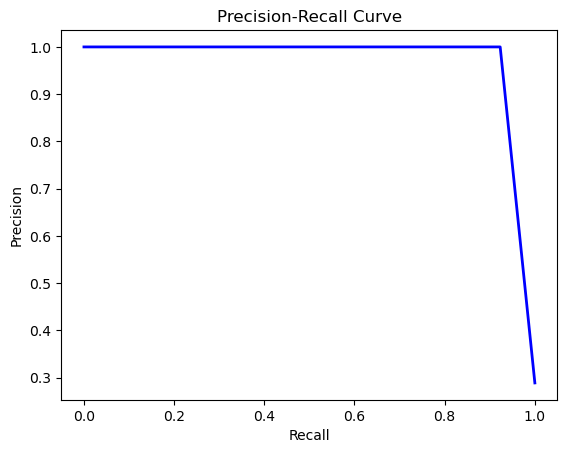

In [333]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()